In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

## Ejercicio 7

Se propone simular la evolución de una epidemia utilizando un modelo basado en agentes, en el cual el desplazamiento se modela como random walking.

Se considera una población de N individuos (utilizar distintos valor de N) distribuidos uniformemente sobre un área de 100 m x 100 m

(Representar esta área como una grilla de celdas de 0,5 x 0,5 m)
Se considera que inicialmente el 2% de los individuos tiene la enfermedad, y existen 3 tipos e individuos:

| Tipo        | Porcentaje  | Caracteristicas
| ----------- | ----------- | -----------
| A.          | 70%         | Se desplaza una celda por instantes de tiempo
| B.          | 25%         | Se desplaza una celda por cada dos instantes de tiempo
| C.          | 5%          | Se desplaza una celda por cada cuatro instantes de tiempo

Esta enfermedad puede ser transmitida con una la siguiente probabilidad:


| Prob        | Distancia entre sano y enfermo 
| ----------- | ----------- 
| 0.5         | 3 < celdas <= 6        
| 0.7         | 3 celdas o menos       


Suponer que las personas contagiadas no se pueden curar.
Realice una simulación hasta 5000 instantes de tiempo, o hasta que la población completa se contagie.

* Una animación de la situación planteada
* Obtenga estadísticas de los tiempos que demoran los individuos en contagiarse. Grafique.
* Graficar la curva de evolución de la epidemia midiendo.
   *  Cantidad de personas sanas en función del tiempo
   * Cantidad de personas enfermas en función del tiempo

In [61]:
TAMANIO_MATRIZ = 100
MOVIMIENTOS_POSIBLES = [(0,-1), (0,1), (1,0), (-1,0)]

class Individuo: 
    def __init__(self, reset_contador, x, y): 
        self.reset_contador = reset_contador
        self.contador = reset_contador
        self.x = x
        self.y = y
        self.infectado = False
        
    def obtener_posicion(self):
        return self.x,self.y
    
    def infectar(self):
        self.infectado = True
        
    def mover(self):
        self.contador -= 1
        if self.contador == 0:
            mov_x, mov_y = random.choice(MOVIMIENTOS_POSIBLES)
            self.x = (self.x + mov_x) % TAMANIO_MATRIZ
            self.y = (self.y + mov_y) % TAMANIO_MATRIZ
            self.contador = self.reset_contador
    
    def esta_infectado(self):
        return self.infectado

In [68]:
class Poblacion:
    def __init__(self, individuos):
        self.individuos = individuos
        self.mapa = [[[] for _ in range(TAMANIO_MATRIZ)] for _ in range(TAMANIO_MATRIZ)]
        for individuo in self.individuos:
            x, y = individuo.obtener_posicion()
            self.mapa[x][y].append(individuo)
        
    def mover_individuos(self):
        nuevas_posiciones = []
        for individuo in self.individuos:
            x_0, y_0 = individuo.obtener_posicion()
            individuo.mover()
            x, y = individuo.obtener_posicion()
            self.mapa[x_0][y_0].remove(individuo)
            self.mapa[x][y].append(individuo)
            nuevas_posiciones.append((x, y))
        return nuevas_posiciones
    
    def calcular_infectados(self):
        for individuo in self.individuos:
            x, y = individuo.obtener_posicion()
            
            posiciones_covid_peligroso = self.obtener_posiciones(x, y, 0, 3)
            for i, j in posiciones_covid_peligroso:
                individuos_a_comparar = self.mapa[i][j]
                for individuo_a_comparar in individuos_a_comparar:
                    if individuo_a_comparar.esta_infectado():
                        p = random.uniform(0,1)
                        if p < 0.7:
                            individuo.infectar()
                            continue
            
            posiciones_covid_cuidadania = self.obtener_posiciones(x, y, 3, 6)
            for i, j in posiciones_covid_cuidadania:
                individuos_a_comparar = self.mapa[i][j]
                for individuo_a_comparar in individuos_a_comparar:
                    if individuo_a_comparar.esta_infectado():
                        p = random.uniform(0,1)
                        if p < 0.5:
                            individuo.infectar()
                            continue
                    
    def obtener_posiciones(self, x, y, lim_inf, lim_sup):
        posiciones = []
        for i in range(lim_inf, lim_sup+1):
            for j in range(lim_inf, lim_sup+1):
                if i + j <= lim_sup and i + j > lim_inf:
                    posiciones.append(((x+i)%TAMANIO_MATRIZ, (y+j)% TAMANIO_MATRIZ))
                    posiciones.append(((x-i)%TAMANIO_MATRIZ, (y+j)% TAMANIO_MATRIZ))
                    posiciones.append(((x+i)% TAMANIO_MATRIZ, (y-j)% TAMANIO_MATRIZ))
                    posiciones.append(((x-i)% TAMANIO_MATRIZ, (y-j)% TAMANIO_MATRIZ))
        posiciones = list(dict.fromkeys(posiciones))
        return posiciones
        
    
    def imprimir_mapa(self):
        for x in range(TAMANIO_MATRIZ):
            for y in range(TAMANIO_MATRIZ):
                print(f"({x}, {y}): {len(self.mapa[x][y])}")

In [69]:
CANTIDAD_PERSONAS = 100

personas = []
for i in range(CANTIDAD_PERSONAS):
    rand_x = int(random.uniform(0,TAMANIO_MATRIZ))
    rand_y = int(random.uniform(0,TAMANIO_MATRIZ))
    tipo = random.uniform(0,1)
    reset_counter = 2
    if tipo <= 0.7:
        reset_counter = 1
    if tipo >= 0.95:
        reset_counter = 4
    
    individuo = Individuo(reset_counter, rand_x, rand_y)
    personas.append(individuo)

random.shuffle(personas)
for i in range(int(CANTIDAD_PERSONAS*0.02)):
    personas[i].infectar()
poblacion = Poblacion(personas)

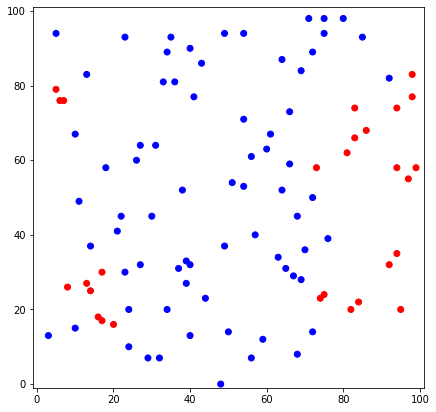

In [70]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(xlim=(-1,TAMANIO_MATRIZ+1),ylim=(-1,TAMANIO_MATRIZ+1))

posiciones_x = []
posiciones_y = []
colores = []
for p in personas:
    posiciones_x.append(p.obtener_posicion()[0])
    posiciones_y.append(p.obtener_posicion()[1])
    if p.infectado:
        colores.append('red')
    else:
        colores.append('blue')

scatter = ax.scatter(posiciones_x, posiciones_y, color=colores)

def update(frame_number):
    posiciones = poblacion.mover_individuos()
    colores = []
    poblacion.calcular_infectados()
    for p in personas:
        if p.esta_infectado():        
            colores.append('red')
        else:
            colores.append('blue')
    scatter.set_offsets(posiciones)
    scatter.set_color(colores)
    return scatter,

anim = FuncAnimation(fig, update, interval=100, frames=200) #todo: change frames to 5000
HTML(anim.to_html5_video())